<h1><h1>Image Classification with PyTorch </h1>


In this project pre-trained models have been used to classify between the negative and positive samples of a dataset. This dataset comprises of images of tiles and the objective is to identify the tiles that have cracks and hence should not be used. The particular pre-trained model used here is resnet18. The following three main tasks have been accomplished using PyTorch:

<ul>
<li>Changed the output layer</li>
<li>Trained the model</li> 
<li>Identified  several  misclassified samples</li> 
 </ul>



<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">

<ul>
    <li><a> Download Data</a></li>
    <li><a> Imports and Auxiliary Functions </a></li>
    <li><a> Dataset Class</a></li>
    <li><a> Prepare a pre-trained resnet18 model</a></li>
    <li><a> Train the Model</a></li>
    <li><a> Missclassified Samples</a></li>
</ul>





<h2 id="download_data">Download Data</h2>


In [1]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 

--2022-06-23 13:48:00--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘Positive_tensors.zip’

Positive_tensors.zi 100%[===================>]   2.42G  30.3MB/s    in 81s     

2022-06-23 13:49:21 (30.7 MB/s) - ‘Positive_tensors.zip’ saved [2598656062/2598656062]



In [2]:
!unzip -q Positive_tensors.zip 

In [3]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

--2022-06-23 13:50:36--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

Negative_tensors.zi 100%[===================>]   1.97G  27.8MB/s    in 69s     

2022-06-23 13:51:46 (29.0 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



Install torchvision:


In [4]:
!pip install torchvision

In [5]:
!pwd

/home/wsuser/work


In [6]:
! cd /home/dsxuser/work/Positive_tensors


/usr/bin/sh: line 0: cd: /home/dsxuser/work/Positive_tensors: No such file or directory


In [7]:
!ls

Negative_tensors  Negative_tensors.zip	Positive_tensors  Positive_tensors.zip


In [8]:
!pwd

/home/wsuser/work


In [9]:
!cd /home/wsuser/work/Positive_tensors
!ls

Negative_tensors  Negative_tensors.zip	Positive_tensors  Positive_tensors.zip


In [10]:
!ls

Negative_tensors  Negative_tensors.zip	Positive_tensors  Positive_tensors.zip


<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries required. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.


In [11]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [12]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


<h2 id="data_class">Dataset Class</h2>


Build the dataset class 


In [13]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/home/dsxuser/work"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        positive_file_path='/home/wsuser/work/Positive_tensors'
        print(positive_file_path)
        negative_file_path=os.path.join(directory,negative)
        negative_file_path='/home/wsuser/work/Negative_tensors'
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


Create two dataset objects, one for the training data and one for the validation data.


In [14]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

/home/wsuser/work/Positive_tensors
/home/wsuser/work/Positive_tensors
done


<h2>Prepare a pre-trained resnet18 model :</h2>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:


In [ ]:
# Step 1: Load the pre-trained model resnet18

model=models.resnet18(pretrained=True)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

composed = transforms.Compose([transforms.Resize(224),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)])

<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [16]:
# Step 2: Set the parameter cannot be trained for the pre-trained model

for param in model.parameters():
    param.requires_grad=False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs.


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code>  the last hidden layer has 512 neurons.


In [17]:
model.fc=nn.Linear(512,2)

In [18]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2>Train the Model</h2>


<b>Step 1</b>: Create a cross entropy criterion function


In [19]:
# Step 1: Create the loss function

criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.


In [20]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader=torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

<b>Step 3</b>: Use the following optimizer to minimize the loss


In [21]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->


Calculating the accuracy on the validation data for one epoch


In [22]:
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs

Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    for x, y in train_loader:

        model.train() 
        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        z=model(x)
        # calculate loss 
        loss=criterion(z,y)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
        loss_list.append(loss.data)
    correct=0
    for x_test, y_test in validation_loader:
        # set model to eval 
        model.eval()
        #make a prediction 
        z=model(x_test)
        #find max 
        _, yhat= torch.max(z.data,1)
       
        #Calculate misclassified  samples in mini-batch 
        #hint +=(yhat==y_test).sum().item()
        correct +=(yhat==y_test).sum().item()
   
    accuracy=correct/N_test
    accuracy_list.append(accuracy)
       
   
    



Accuracy


In [26]:
accuracy

0.9935

Loss Plot

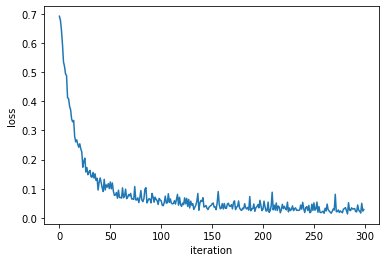

In [40]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


<h2>Misclassified samples</h2> 


<b>Identifying the first four misclassified samples using the validation data:</b>


In [41]:
sampleSeq=0
N_samples=0

for x_test, y_test in validation_loader:
    model.eval()
    z=model(x_test)
    _, yhat=torch.max(z.data,1)
    
    for i in range(len(y_test)):
        sampleSeq += 1
        if yhat[i] != y_test[i]:
            print("sample#: %d - predicted value: %d - actual value: %d" % (sampleSeq, yhat[i], y_test[i]))
            N_samples += 1
            if N_samples >= 4:
                break
    if N_samples >=4:
        break
        
print("done!")

sample#: 2 - predicted value: 1 - actual value: 0
sample#: 27 - predicted value: 0 - actual value: 1
sample#: 80 - predicted value: 1 - actual value: 0
sample#: 246 - predicted value: 1 - actual value: 0
done!
